In [22]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

In [23]:
def c_amod15(a, power):
    U = QuantumCircuit(4)        
    for iteration in range(power):
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

In [24]:
def qft_dagger(n):
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT Dagger"
    return qc

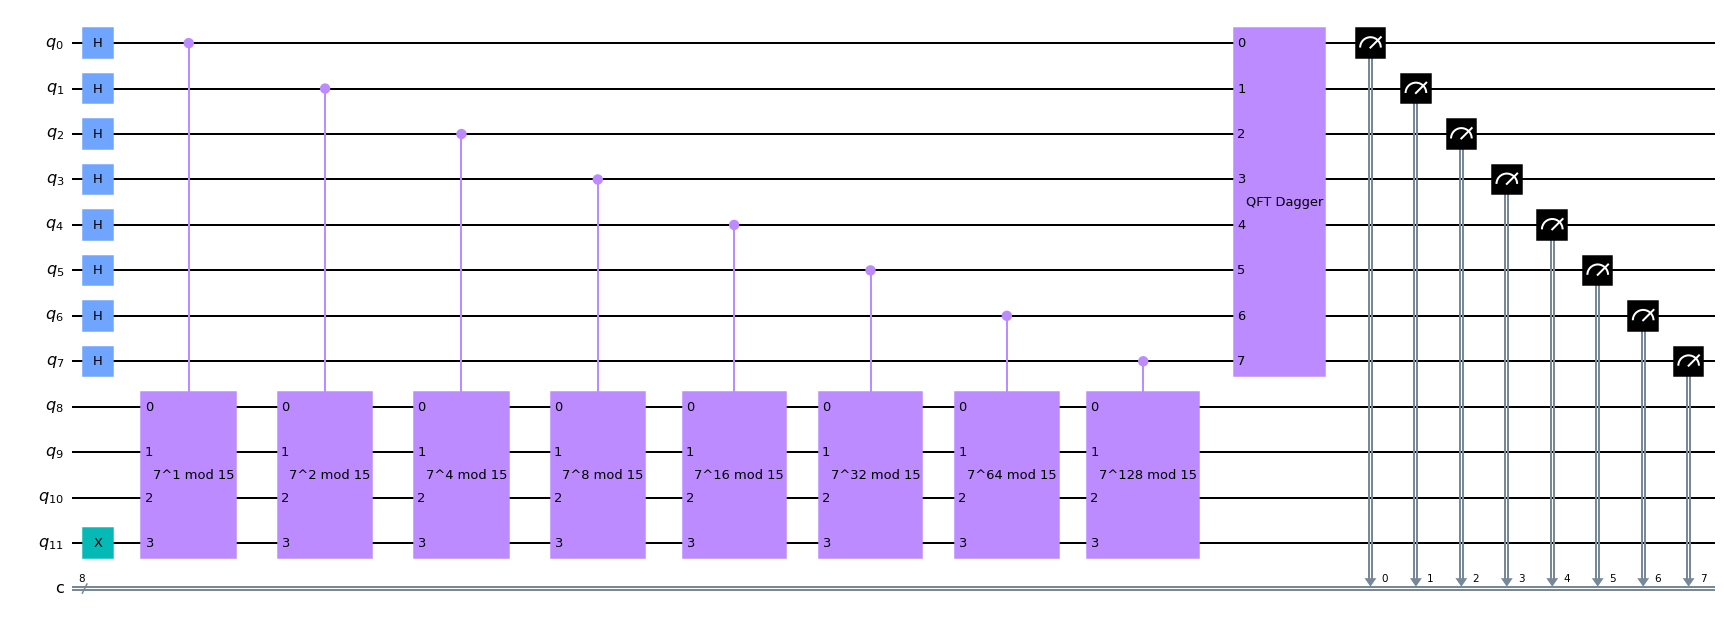

In [25]:
n_count = 8
a = 7

qc = QuantumCircuit(n_count + 4, n_count) # plus 4 qubits for U to act on

for q in range(n_count):
    qc.h(q)
    
# Put auxiliary register in state |1>
qc.x(3+n_count)

# Controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(output = 'mpl', fold= -1)

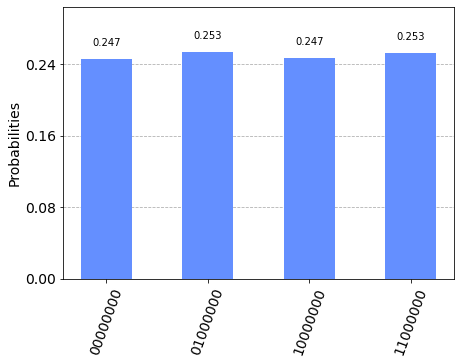

In [26]:
sim = Aer.get_backend('qasm_simulator')
result = execute(qc, backend = sim, shots = 2048).result()
counts = result.get_counts()
plot_histogram(counts)

In [27]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  11000000(bin) = 192(dec)  192/256 = 0.75
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  00000000(bin) =   0(dec)    0/256 = 0.00
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [28]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.75      3/4            4
1   0.25      1/4            4
2   0.00      0/1            1
3   0.50      1/2            2
